In [ ]:
# Retrieval-Augmented Generation (RAG) Chatbot for Quantum Computing

## Project Overview
This project builds a Retrieval-Augmented Generation (RAG) system integrating LangChain, ChromaDB, and an OpenAI LLM to create a quantum computing chatbot. It loads a quantum computing dataset from Hugging Face, processes instruction–output pairs into document chunks, and generates embeddings for semantic retrieval and visualization.


In [23]:
import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [24]:
from datasets import load_dataset
from langchain.schema import Document
from langchain.text_splitter import CharacterTextSplitter
from langchain_chroma import Chroma
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
from langchain_openai import  ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

In [25]:
# Load environment variables  from .env file (not included)

load_dotenv(override=True)
api_key = os.getenv('OPENAI_API_KEY')

# Check the key

if not api_key:
    print("No API key was found")
elif not api_key.startswith("sk-proj-"):
    print("An API key was found, but it doesn't start sk-proj-; please check you're using the right key")
elif api_key.strip() != api_key:
    print("An API key was found, but it looks like it might have space or tab characters at the start or end - please remove them")
else:
    print("API key found and looks good so far!")


API key found and looks good so far!


In [26]:
MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [27]:


dataset = load_dataset("Tonmoy-000/quantumcomputingecosystem_dataset", split="train") 

text_column = "instruction"
answer_column = "output"

def add_metadata(record):
    metadata = {k: v for k, v in record.items() if k not in [text_column, answer_column]}
    metadata["doc_type"] = "quantum_dataset"

    # combine instruction  + output columns (form dataset) in page_content
    content = f"Instruction: {record[text_column]}\nAnswer: {record[answer_column]}"
    return Document(page_content=content, metadata=metadata)

documents = [add_metadata(record) for record in dataset if record.get(text_column)]    

# text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
chunks = text_splitter.split_documents(documents)

print(f"Total number of chunks: {len(chunks)}")
print(f"Loaded {len(documents)} documents from dataset")                     
                      

Total number of chunks: 1041
Loaded 1041 documents from dataset


In [15]:
for i, chunk in enumerate(chunks[:5]):
    print(f"Chunk {i}: {len(chunk.page_content)} chars")
    

Chunk 0: 194 chars
Chunk 1: 205 chars
Chunk 2: 246 chars
Chunk 3: 235 chars
Chunk 4: 161 chars


In [16]:
# vectorize chunks of data
from langchain.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

if os.path.exists(db_name):
    # Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()
    Chroma(persist_directory=db_name).delete_collection()

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 1041 documents


In [17]:
collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 1,041 vectors with 384 dimensions in the vector store


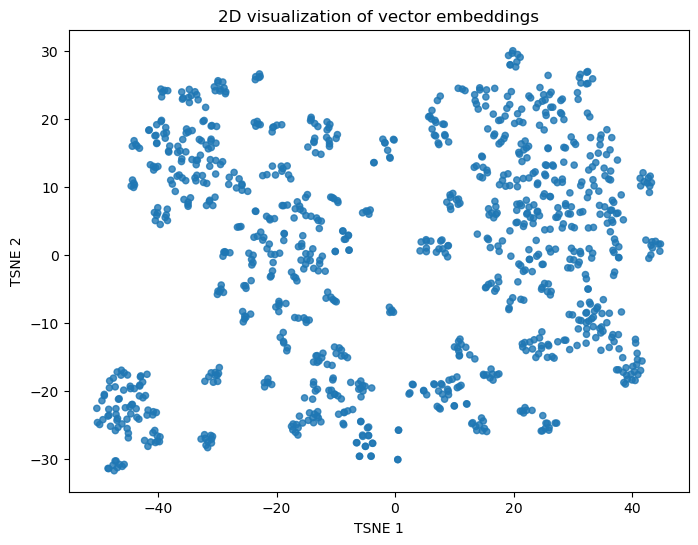

In [18]:

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]


unique_doc_types = list(set(doc_types))
cmap = plt.get_cmap("tab10", len(unique_doc_types))
color_map = {t: cmap(i) for i, t in enumerate(unique_doc_types)}
colors = [color_map[t] for t in doc_types]

# reduce dimensionality with T SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# plot 2d scatter 
plt.figure(figsize=(8,6))
plt.scatter(
    reduced_vectors[:, 0],
    reduced_vectors[:, 1],
    c=colors,
    s=20,
    alpha=0.8
)

plt.title("2D visualization of vector embeddings")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()


In [19]:
tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# create 3d scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [20]:
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)
retriever = vectorstore.as_retriever()
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [21]:
def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

In [22]:
view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
